In [1]:
import os
import yaml
from torch.utils.data import DataLoader
import argparse

from GeospatialFM.data import get_datasets
from GeospatialFM.models import *
# from utils import load_config
from torchgeo.samplers import RandomGeoSampler
from matplotlib import pyplot as plt

from transformers import TrainingArguments, Trainer
from transformers import AdamW, get_linear_schedule_with_warmup
from GeospatialFM.utils import setup, get_eval_fn, get_data
from GeospatialFM.data import *
from GeospatialFM.models import *
from GeospatialFM.loss import *

from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
import numpy as np
from torch.utils.data import ConcatDataset
import segmentation_models_pytorch as smp
from collections import OrderedDict

%load_ext autoreload
%autoreload 2

/home/haozhesi/anaconda3/envs/sat/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def unwrap_model(state_dict):
    new_state_dict = OrderedDict()
    for key, value in state_dict.items():
        new_key = key.replace('module.', '')
        new_state_dict[new_key] = value
    
    return new_state_dict

def decompose_model(state_dict):
    optical_model = OrderedDict()
    radar_model = OrderedDict()
    for key, value in state_dict.items():
        try:
            key_prefix, key_name = key.split('.', 1)
        except:
            print(key)
            continue
        if 'optical_encoder' in key_prefix:
            optical_model[key_name] = value
        elif 'radar_encoder' in key_prefix:
            radar_model[key_name] = value
    return optical_model, radar_model

In [3]:
exp_name = "mae_base_clip"
device = torch.device('cuda:0')

In [22]:
args = {'exp_name': exp_name,
        'config_file': 'GeospatialFM/configs/finetune_mae.yaml',
        'opts': None, 
        'save_config': False}
args = argparse.Namespace(**args)
args.debug = True
args

Namespace(exp_name='mae_base_clip', config_file='GeospatialFM/configs/finetune_mae.yaml', opts=None, save_config=False, debug=True)

In [23]:
cfg, _ = setup(args)

In [24]:
cfg['MODEL']

{'architecture': 'vit_base_patch16_224', 'cross_modal': True, 'unified_decoder': False, 'mask_ratio': 0.75, 'freeze_encoder': False, 'OPTICAL': {'load_pretrained_from': None, 'pretrained_ckpt': None, 'freeze_encoder': False, 'kwargs': {'img_size': 224, 'patch_size': 16, 'in_chans': 13, 'embed_dim': 768, 'depth': 12, 'num_heads': 12, 'mlp_ratio': 4.0, 'qkv_bias': True, 'drop_path_rate': 0.0, 'drop_path_uniform': False, 'init_values': None, 'num_register_tokens': 0}, 'use_head': True, 'head_kwargs': {'head_type': 'linear', 'task_type': 'classification', 'use_bias': True, 'in_features': 768, 'num_classes': 19}}, 'RADAR': {'load_pretrained_from': None, 'pretrained_ckpt': None, 'freeze_encoder': False, 'kwargs': {'img_size': 224, 'patch_size': 16, 'in_chans': 2, 'embed_dim': 768, 'depth': 12, 'num_heads': 12, 'mlp_ratio': 4.0, 'qkv_bias': True, 'drop_path_rate': 0.0, 'drop_path_uniform': False, 'init_values': None, 'num_register_tokens': 0}, 'use_head': True, 'head_kwargs': {'head_type': 'l

In [7]:
model = construct_downstream_models(cfg.MODEL)

In [8]:
save_path = os.path.join(cfg.TRAINER['output_dir'], 'final_model.pth')
state_dict = unwrap_model(torch.load(save_path, map_location='cpu'))
optical_state_dict, radar_state_dict = decompose_model(state_dict)

logit_scale


In [9]:
model['OPTICAL'].encoder.load_state_dict(optical_state_dict, strict=False)
model['RADAR'].encoder.load_state_dict(radar_state_dict, strict=False)

<All keys matched successfully>

In [10]:
optical_model = model['OPTICAL']
radar_model = model['RADAR']

In [11]:
data = get_data(cfg)
data

{'train': DataInfo(dataloader=<torch.utils.data.dataloader.DataLoader object at 0x7fb45118fe50>, sampler=None, shared_epoch=None),
 'val': DataInfo(dataloader=<torch.utils.data.dataloader.DataLoader object at 0x7fb45118ebc0>, sampler=None, shared_epoch=None),
 'test': DataInfo(dataloader=<torch.utils.data.dataloader.DataLoader object at 0x7fb45118fd00>, sampler=None, shared_epoch=None)}

In [12]:
sample = iter(data['train'].dataloader).__next__()

In [13]:
sample['image'].shape

torch.Size([256, 13, 224, 224])

In [14]:
device = 'cuda:1'
device_ids = [0, 1]

In [15]:
optical_model = optical_model.to(device)
# optical_model = torch.nn.DataParallel(optical_model, device_ids=device_ids)

In [25]:
loss = get_loss_list(cfg.LOSS)

In [26]:
loss

[CrossEntropyLoss()]

In [18]:
# device = torch.device(device)

In [19]:
image = sample['image'].to(device, non_blocking=True)
# radar = sample['radar'].to(device, non_blocking=True)
label = sample['label'].to(device, non_blocking=True)

In [20]:
image.shape

torch.Size([256, 13, 224, 224])

In [21]:
model_out = optical_model(image)
model_out

tensor([[ 0.4058, -0.3998, -0.0111,  ..., -0.5894,  0.2457,  0.0899],
        [ 0.4110, -0.4903, -0.0170,  ..., -0.6057,  0.2723,  0.1539],
        [ 0.2948, -0.4075,  0.0363,  ..., -0.6678,  0.3062,  0.1715],
        ...,
        [ 0.3569, -0.3916,  0.0259,  ..., -0.6164,  0.2849,  0.1839],
        [ 0.3939, -0.3376, -0.0892,  ..., -0.6118,  0.2855,  0.1511],
        [ 0.4096, -0.3709, -0.0109,  ..., -0.6060,  0.2692,  0.1749]],
       device='cuda:1', grad_fn=<AddmmBackward0>)

In [28]:
loss[0](model_out, label)

tensor(3.1706, device='cuda:1', grad_fn=<NllLossBackward0>)

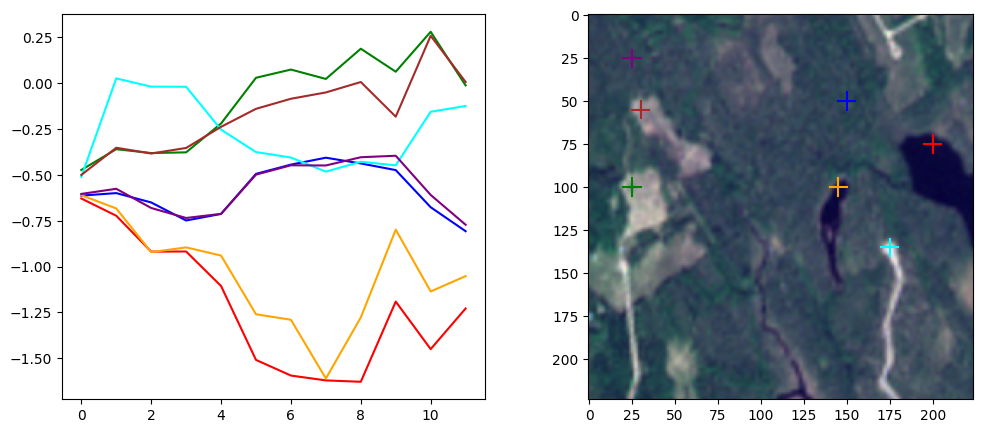

In [75]:
points = [[75, 200], [100, 25], [50, 150], [135, 175], [100, 145], [25, 25], [55, 30]]
cross_length = 5
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
color = ['r', 'g', 'b', 'cyan', 'orange', 'purple', 'brown']
for c, point in enumerate(points):
    curve = image[0, :, point[0], point[1]].detach().cpu().numpy()
    curve = np.delete(curve, 10)
    plt.plot(np.arange(12), curve, color[c])
vis_img = image[0, [3, 2, 1], :, :].detach().cpu().numpy().transpose(1, 2, 0)
# normalize each channel
vis_img = (vis_img - vis_img.min()) / (vis_img.max() - vis_img.min())

plt.subplot(1, 2, 2)
plt.imshow(vis_img)
# draw a cross at the point
for c, point in enumerate(points):
    plt.plot([point[1] - cross_length, point[1] + cross_length], [point[0], point[0]],  color[c]) 
    # Draw vertical line of the cross
    plt.plot([point[1], point[1]], [point[0] - cross_length, point[0] + cross_length],  color[c]) 
# plt.axis('off')